In [11]:
from one.api import ONE
one = ONE()
assert not one.offline, 'ONE must be connect to Alyx for searching imaging sessions'
from datetime import datetime
import pandas as pd
import numpy as np

In [12]:
sessions = pd.read_csv('../good_mesoscope_sessions_final.csv')

In [13]:
sessions

,eid,subject,date,duration_hours,task_protocol,good_fov_count,total_rois
0,61f260e7-b5d3-4865-a577-bcfc53fda8a8,SP066,2025-04-09T12:10:56.318000,1.084390,_iblrig_tasks_biasedChoiceWorld8.27.6/_sp_pass...,8,25809
1,5ea6bb9b-6163-4e8a-816b-efe7002666b0,SP063,2025-03-18T12:43:09.790000,1.204264,_iblrig_tasks_biasedChoiceWorld8.27.1/_sp_pass...,8,31661
2,d682fbb9-4fd9-450c-9812-e7c32f754a42,SP063,2025-03-17T12:49:16.696000,1.171964,_iblrig_tasks_biasedChoiceWorld8.27.1/_sp_pass...,8,26159
3,dd45de54-6b3c-443a-949d-e74954fc33b2,SP061,2024-12-18T11:15:29.828000,1.030319,_iblrig_tasks_biasedChoiceWorld8.26.0/_sp_pass...,8,28727
4,3f8c0614-5bd4-4c35-b13e-042e25823a64,SP061,2024-12-13T10:17:43.842000,1.014481,_iblrig_tasks_biasedChoiceWorld8.26.0/_sp_pass...,8,27265
5,7ba8c055-a1a8-4cf9-9acf-1c43f2a99dbf,SP061,2024-11-13T14:13:16,1.057500,_iblrig_tasks_trainingChoiceWorld8.24.7/_iblri...,8,27115
6,00fbcc3f-9ee1-4993-9f94-ce8be232752c,SP061,2024-11-08T11:51:36,1.195833,_iblrig_tasks_trainingPhaseChoiceWorld8.24.7/_...,8,27991
7,727b4408-49d4-4742-85c8-323cd187f5fa,SP060,2024-10-02T11:22:29,1.128056,samuel_cuedBiasedChoiceWorld8.23.1+dirty/_iblr...,8,34031
8,b7f5b6ee-5ec9-4c8f-8ae7-d07f6303f223,SP060,2024-10-01T10:41:25,1.149722,samuel_cuedBiasedChoiceWorld8.23.1+dirty/_iblr...,8,31025
9,b52efb6c-f3b8-41c7-895f-365be2b3fc78,SP060,2024-09-30T10:46:01,1.211944,samuel_cuedBiasedChoiceWorld8.23.1+dirty/_iblr...,8,32019


In [14]:
sessions.loc[0]['eid']

'61f260e7-b5d3-4865-a577-bcfc53fda8a8'

Loaded 10 good mesoscope sessions

Selected session 9:
Subject: SP060
Date: 2024-09-30T10:46:01
Duration: 1.21 hours
FOVs: 8
Total ROIs: 32019

Found 8 FOV collections: ['alf/FOV_00', 'alf/FOV_01', 'alf/FOV_02', 'alf/FOV_03', 'alf/FOV_04', 'alf/FOV_05', 'alf/FOV_06', 'alf/FOV_07']
Loading data from alf/FOV_00...
  - Successfully loaded brain locations
  - Brain locations shape: (4235,)
  - Successfully loaded ROI types
  - ROI types shape: (4235,)
  - ROI types data type: <class 'numpy.ndarray'>
  - ROI types unique values: [0 1]
  - alf/FOV_00: 4235 ROIs (1241 neurons), 22046/22046 good frames
Loading data from alf/FOV_01...
  - Successfully loaded brain locations
  - Brain locations shape: (4684,)
  - Successfully loaded ROI types
  - ROI types shape: (4684,)
  - ROI types data type: <class 'numpy.ndarray'>
  - ROI types unique values: [0 1]
  - alf/FOV_01: 4684 ROIs (1026 neurons), 22046/22046 good frames
Loading data from alf/FOV_02...
  - Successfully loaded brain locations
  - Br

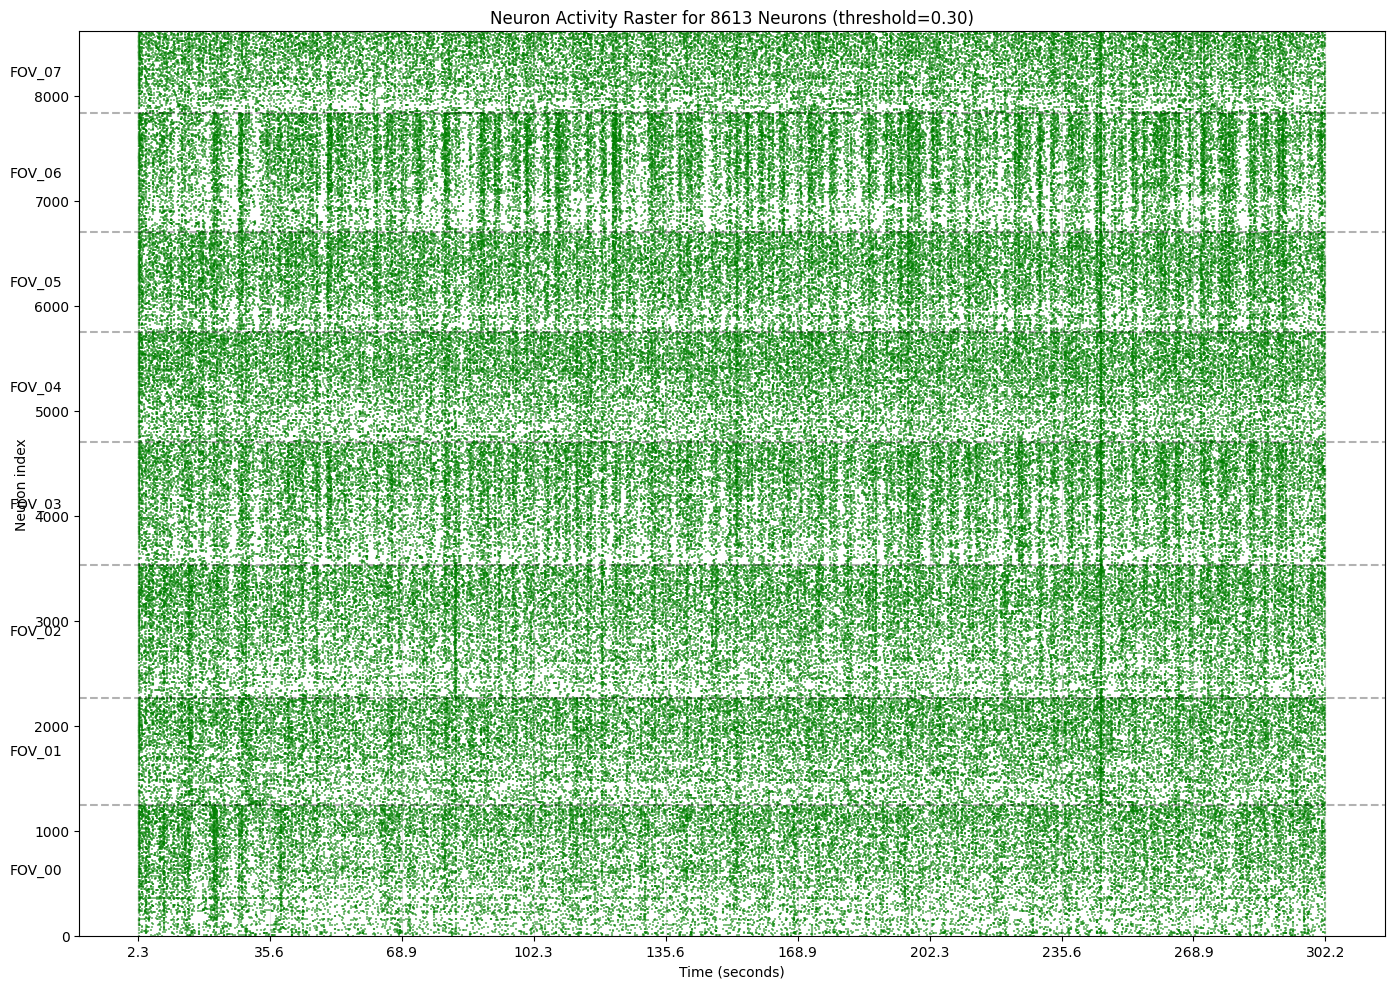

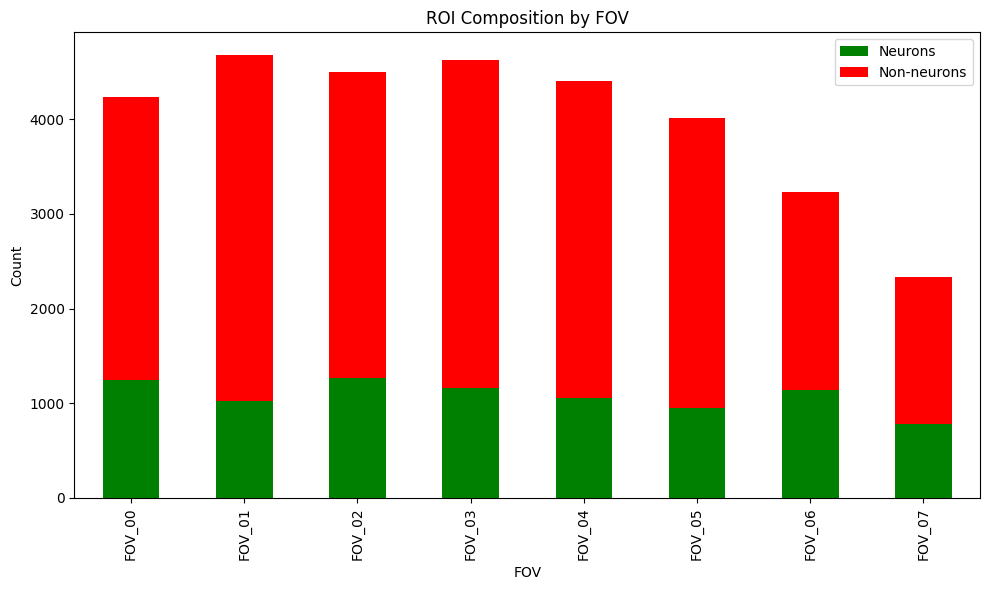

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from one.api import ONE
from iblutil.util import Bunch
import seaborn as sns

# Load the sessions dataframe
sessions = pd.read_csv('../good_mesoscope_sessions_final.csv')
print(f"Loaded {len(sessions)} good mesoscope sessions")

# Select a session for analysis
selected_session_index = 9  # Change this to select a different session
selected_session = sessions.iloc[selected_session_index]
eid = selected_session['eid']

print(f"\nSelected session {selected_session_index}:")
print(f"Subject: {selected_session['subject']}")
print(f"Date: {selected_session['date']}")
print(f"Duration: {selected_session['duration_hours']:.2f} hours")
print(f"FOVs: {selected_session['good_fov_count']}")
print(f"Total ROIs: {selected_session['total_rois']}")

# Connect to ONE API
one = ONE()

# Get the FOV collections for this session
all_datasets = one.list_datasets(eid)
fov_collections = set()
for dataset in all_datasets:
    if 'mpci' in dataset and 'FOV_' in dataset:
        parts = dataset.split('/')
        if len(parts) >= 2:
            collection = '/'.join(parts[:-1])
            fov_collections.add(collection)

fov_collections = sorted(list(fov_collections))
print(f"\nFound {len(fov_collections)} FOV collections: {fov_collections}")

# Function to load data from a FOV, including ROI types and brain locations
def load_fov_data(one, eid, collection):
    print(f"Loading data from {collection}...")
    
    # Load the key datasets
    roi_activity = one.load_dataset(eid, 'mpci.ROIActivityDeconvolved', collection=collection)
    timestamps = one.load_dataset(eid, 'mpci.times', collection=collection)
    bad_frames = one.load_dataset(eid, 'mpci.badFrames', collection=collection)
    frame_qc = one.load_dataset(eid, 'mpci.mpciFrameQC', collection=collection)
    
    # Try to load brain locations - only use ccf_2017_estimate path
    brain_locations = None
    try:
        brain_locations = one.load_dataset(eid, 'mpciROIs.brainLocationIds_ccf_2017_estimate', collection=collection)
        print(f"  - Successfully loaded brain locations")
        # Check the shape to understand the structure
        print(f"  - Brain locations shape: {brain_locations.shape if hasattr(brain_locations, 'shape') else 'Not an array'}")
    except Exception as e:
        print(f"  - Could not load brain locations: {str(e)}")
    
    # Try to load ROI types
    roi_types = None
    try:
        roi_types = one.load_dataset(eid, 'mpciROIs.mpciROITypes', collection=collection)
        print(f"  - Successfully loaded ROI types")
        # Check the data type and shape
        print(f"  - ROI types shape: {roi_types.shape if hasattr(roi_types, 'shape') else 'Not an array'}")
        print(f"  - ROI types data type: {type(roi_types)}")
        if hasattr(roi_types, 'shape'):
            print(f"  - ROI types unique values: {np.unique(roi_types)}")
    except Exception as e:
        print(f"  - Could not load ROI types: {str(e)}")

    # Print basic info
    n_frames, n_rois = roi_activity.shape
    good_frame_mask = (bad_frames == 0) & (frame_qc == 0)
    n_good_frames = np.sum(good_frame_mask)
    
    # Count neurons if ROI types are available
    n_neurons = 0
    if roi_types is not None:
        # Make sure roi_types is properly converted to an array
        roi_types_array = np.array(roi_types)
        n_neurons = np.sum(roi_types_array == 1)
        print(f"  - {collection}: {n_rois} ROIs ({n_neurons} neurons), {n_good_frames}/{n_frames} good frames")
    else:
        print(f"  - {collection}: {n_rois} ROIs (unknown neuron count), {n_good_frames}/{n_frames} good frames")
    
    # Store data in a dictionary
    fov_data = {
        'roi_activity': roi_activity,
        'timestamps': timestamps,
        'bad_frames': bad_frames,
        'frame_qc': frame_qc,
        'roi_types': roi_types,
        'brain_locations': brain_locations,
        'collection': collection,
        'fov_name': collection.split('/')[-1]
    }
    
    return fov_data

# Load data from all FOVs
num_fovs_to_load = min(8, len(fov_collections))  # Load up to 8 FOVs
selected_fovs = fov_collections[:num_fovs_to_load]
fov_data_dict = {}

for fov in selected_fovs:
    fov_name = fov.split('/')[-1]  # Extract FOV name (e.g., 'FOV_00')
    fov_data_dict[fov_name] = load_fov_data(one, eid, fov)

# Function to combine data from all FOVs
def combine_fov_data(fov_data_dict, time_window=300):
    """Combine data from all FOVs into a single matrix"""
    print("Combining data from all FOVs...")
    
    # Create lists to store combined data
    all_roi_activities = []
    all_roi_types = []
    all_brain_locations = []
    all_fov_indices = []  # To track which FOV each ROI belongs to
    
    # First pass: determine common time points and process each FOV
    processed_fovs = []
    all_timepoints = []
    
    for fov_name, fov_data in fov_data_dict.items():
        # Filter out bad frames
        good_frame_mask = (fov_data['bad_frames'] == 0) & (fov_data['frame_qc'] == 0)
        filtered_timestamps = fov_data['timestamps'][good_frame_mask]
        
        # Verify we have data left after filtering
        if len(filtered_timestamps) == 0:
            print(f"  - Skipping {fov_name}: No good frames")
            continue
            
        # Select a subset based on time window if specified
        if time_window is not None:
            time_limit = filtered_timestamps[0] + time_window
            time_mask = filtered_timestamps <= time_limit
            if not np.any(time_mask):
                print(f"  - Skipping {fov_name}: No data within time window")
                continue
            filtered_timestamps = filtered_timestamps[time_mask]
        
        all_timepoints.append(filtered_timestamps)
        processed_fovs.append(fov_name)
    
    if not processed_fovs:
        print("No valid FOVs to combine!")
        return None
    
    # Now process the data for each valid FOV
    for fov_name in processed_fovs:
        fov_data = fov_data_dict[fov_name]
        
        # Get filtered activity and timestamps
        good_frame_mask = (fov_data['bad_frames'] == 0) & (fov_data['frame_qc'] == 0)
        filtered_activity = fov_data['roi_activity'][good_frame_mask, :]
        filtered_timestamps = fov_data['timestamps'][good_frame_mask]
        
        # Apply time window if specified
        if time_window is not None:
            time_limit = filtered_timestamps[0] + time_window
            time_mask = filtered_timestamps <= time_limit
            filtered_activity = filtered_activity[time_mask, :]
            filtered_timestamps = filtered_timestamps[time_mask]
        
        # Get ROI types if available
        if fov_data['roi_types'] is not None:
            roi_types = np.array(fov_data['roi_types'])
        else:
            # If ROI types not available, assume all are non-neurons
            roi_types = np.zeros(filtered_activity.shape[1], dtype=int)
        
        # Get brain locations if available
        if fov_data['brain_locations'] is not None:
            brain_locations = fov_data['brain_locations']
        else:
            # If brain locations not available, use placeholder values
            brain_locations = None
        
        # Store data
        all_roi_activities.append(filtered_activity)
        all_roi_types.append(roi_types)
        all_brain_locations.append(brain_locations)
        
        # Store FOV index for each ROI
        fov_idx = processed_fovs.index(fov_name)
        all_fov_indices.append(np.full(filtered_activity.shape[1], fov_idx))
    
    # Check if we have any data to work with
    if not all_roi_activities:
        print("No valid activity data to combine!")
        return None
    
    # For visualization, we'll use the timestamps from the first FOV
    # In a more sophisticated analysis, you might want to align/interpolate timestamps
    reference_timestamps = all_timepoints[0]
    
    # Create combined data structure
    combined_data = {
        'activities': all_roi_activities,
        'roi_types': all_roi_types,
        'brain_locations': all_brain_locations,
        'fov_indices': all_fov_indices,
        'timestamps': reference_timestamps,
        'fov_names': processed_fovs,
        'n_fovs': len(processed_fovs),
        'n_rois_per_fov': [act.shape[1] for act in all_roi_activities]
    }
    
    print(f"Combined data from {len(processed_fovs)} FOVs:")
    print(f"  - Total ROIs: {sum(combined_data['n_rois_per_fov'])}")
    print(f"  - Time points: {len(reference_timestamps)}")
    print(f"  - ROIs per FOV: {combined_data['n_rois_per_fov']}")
    
    return combined_data

# Create a function to plot combined raster (neurons only)
def plot_neurons_raster(combined_data, threshold=0.3, max_rois=300):
    """Create a raster plot of neuron activity for all FOVs combined (only neurons)"""
    if combined_data is None:
        print("No combined data to plot!")
        return None
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Keep track of total neurons and their indices
    total_neurons = 0
    neuron_indices = []
    
    # First pass: count total neurons to allocate vertical space
    for roi_types in combined_data['roi_types']:
        if roi_types is None:
            continue
        neuron_count = np.sum(roi_types == 1)
        total_neurons += neuron_count
    
    print(f"Total neurons across all FOVs: {total_neurons}")
    if total_neurons == 0:
        print("No neurons found in the data!")
        ax.text(0.5, 0.5, "No neurons found in the data!", 
               ha='center', va='center', transform=ax.transAxes)
        return fig
    
    # Keep track of the neuron starting index for each FOV
    neuron_start_index = 0
    
    # Process each FOV's data
    for fov_idx, (activity, roi_types, fov_indices) in enumerate(zip(
            combined_data['activities'], 
            combined_data['roi_types'], 
            combined_data['fov_indices'])):
        
        # Skip if no ROI types
        if roi_types is None:
            print(f"No ROI types for FOV {combined_data['fov_names'][fov_idx]}")
            continue
        
        # Find neuron indices
        neuron_mask = roi_types == 1
        if not np.any(neuron_mask):
            print(f"No neurons found in FOV {combined_data['fov_names'][fov_idx]}")
            continue
        
        # Get neuron activity
        neuron_activity = activity[:, neuron_mask]
        n_neurons = neuron_activity.shape[1]
        
        # Normalize activity per neuron
        normalized_data = np.zeros_like(neuron_activity)
        for r in range(neuron_activity.shape[1]):
            roi_max = np.max(neuron_activity[:, r])
            if roi_max > 0:  # Avoid division by zero
                normalized_data[:, r] = neuron_activity[:, r] / roi_max
        
        # Find activity above threshold
        binary_activity = normalized_data > threshold
        
        # Skip if no activity above threshold
        if not np.any(binary_activity):
            print(f"No activity above threshold for neurons in FOV {combined_data['fov_names'][fov_idx]}")
            neuron_start_index += n_neurons  # Still increment the starting index
            continue
        
        # Find active points
        active_points = np.where(binary_activity.T)
        
        if len(active_points) >= 2 and len(active_points[0]) > 0:
            active_neurons = active_points[0] + neuron_start_index  # Offset neuron indices
            active_time_indices = active_points[1]
            
            # Make sure time indices are valid
            valid_indices = active_time_indices < len(combined_data['timestamps'])
            if not np.any(valid_indices):
                print(f"No valid time indices for FOV {combined_data['fov_names'][fov_idx]}")
                neuron_start_index += n_neurons  # Still increment the starting index
                continue
                
            active_neurons = active_neurons[valid_indices]
            active_time_indices = active_time_indices[valid_indices]
            
            # Plot neuron activity
            ax.scatter(
                combined_data['timestamps'][active_time_indices], 
                active_neurons,
                s=1, 
                color='green', 
                alpha=0.5, 
                marker='|'
            )
        
        # Update neuron starting index for next FOV
        neuron_start_index += n_neurons
    
    # Add labels and title
    ax.set_title(f"Neuron Activity Raster for {total_neurons} Neurons (threshold={threshold:.2f})")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Neuron index")
    ax.set_ylim(-1, total_neurons)
    
    # Add horizontal lines to separate FOVs
    neuron_count = 0
    for fov_idx, roi_types in enumerate(combined_data['roi_types']):
        if roi_types is None:
            continue
        
        n_neurons = np.sum(roi_types == 1)
        neuron_count += n_neurons
        if neuron_count > 0:
            ax.axhline(neuron_count, color='black', linestyle='--', alpha=0.3)
    
    # Add FOV labels
    neuron_count = 0
    for fov_idx, roi_types in enumerate(combined_data['roi_types']):
        if roi_types is None:
            continue
            
        n_neurons = np.sum(roi_types == 1)
        if n_neurons > 0:
            middle_pos = neuron_count + n_neurons / 2
            ax.text(-30, middle_pos, combined_data['fov_names'][fov_idx], 
                   verticalalignment='center', fontsize=10)
            neuron_count += n_neurons
    
    # Set x-ticks for better readability
    time_range = combined_data['timestamps'][-1] - combined_data['timestamps'][0]
    tick_interval = 30  # seconds
    n_ticks = int(time_range / tick_interval) + 1
    ticks = np.linspace(combined_data['timestamps'][0], combined_data['timestamps'][-1], n_ticks)
    ax.set_xticks(ticks)
    
    # Add a grid for better visualization
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig


# Combine data from all FOVs
combined_data = combine_fov_data(fov_data_dict, time_window=300)

# Plot neurons raster (only neurons)
fig_neurons = plot_neurons_raster(combined_data, threshold=0.3)


# Create a summary of neuron counts per FOV
if combined_data is not None:
    neuron_counts = []
    for fov_idx, roi_types in enumerate(combined_data['roi_types']):
        if roi_types is not None:
            roi_types_array = np.array(roi_types)
            n_neurons = np.sum(roi_types_array == 1)
            n_total = len(roi_types_array)
        else:
            n_neurons = 0
            n_total = combined_data['n_rois_per_fov'][fov_idx]
        
        neuron_counts.append({
            'FOV': combined_data['fov_names'][fov_idx],
            'Neurons': n_neurons,
            'Non-neurons': n_total - n_neurons,
            'Total ROIs': n_total,
            'Neuron %': (n_neurons / n_total * 100) if n_total > 0 else 0
        })
    
    # Create a summary table
    neuron_df = pd.DataFrame(neuron_counts)
    print("\nNeuron counts per FOV:")
    print(neuron_df)
    
    # Create a bar chart of neuron counts
    plt.figure(figsize=(10, 6))
    neuron_df.plot(
        x='FOV', 
        y=['Neurons', 'Non-neurons'], 
        kind='bar', 
        stacked=True, 
        color=['green', 'red'],
        ax=plt.gca()
    )
    plt.title('ROI Composition by FOV')
    plt.ylabel('Count')
    plt.tight_layout()

# Display figures
plt.show()

In [16]:
# # Function to plot brain locations (handling 1D array case)
# def plot_brain_locations(combined_data, iblatlas=None):
#     """Plot brain locations of ROIs colored by neuron type"""
#     if combined_data is None:
#         print("No combined data to plot!")
#         return None
    
#     # Check if brain locations are available
#     has_brain_locations = False
#     for brain_locs in combined_data['brain_locations']:
#         if brain_locs is not None and len(brain_locs) > 0:
#             has_brain_locations = True
#             # Check the shape to determine how to process
#             if isinstance(brain_locs, np.ndarray):
#                 print(f"Brain locations shape: {brain_locs.shape}")
#             else:
#                 print(f"Brain locations type: {type(brain_locs)}")
#             break
            
#     if not has_brain_locations:
#         print("No brain locations found in any FOV")
#         return None
    
#     # Try to import the brain atlas
#     try:
#         from iblatlas.atlas import AllenAtlas
#         if iblatlas is None:
#             iblatlas = AllenAtlas()
#         has_atlas = True
#         print("Successfully imported iblatlas")
#     except ImportError:
#         print("iblatlas not available, using simplified brain location plot")
#         has_atlas = False
    
#     # Create figure
#     fig = plt.figure(figsize=(16, 8))
    
#     # Process each FOV's data
#     all_brain_ids = []
#     all_neuron_types = []
#     all_fov_names = []
    
#     for fov_idx, (brain_locs, roi_types) in enumerate(zip(
#             combined_data['brain_locations'],
#             combined_data['roi_types'])):
        
#         # Skip if no brain locations or ROI types
#         if brain_locs is None or roi_types is None:
#             continue
        
#         # Make sure ROI types is an array
#         roi_types_array = np.array(roi_types)
        
#         # Extract neuron mask
#         neuron_mask = roi_types_array == 1
        
#         # Only include neurons
#         if not np.any(neuron_mask):
#             continue
            
#         # Get brain IDs for neurons
#         if isinstance(brain_locs, np.ndarray):
#             # If brain_locs is 1D, it's likely just the brain region IDs
#             if brain_locs.ndim == 1:
#                 neuron_brain_ids = brain_locs[neuron_mask]
#             else:
#                 # Handle multidimensional case - not clear what this would be
#                 print(f"Warning: Unexpected shape for brain locations: {brain_locs.shape}")
#                 continue
#         else:
#             # If not an array, try to convert it
#             try:
#                 brain_locs_array = np.array(brain_locs)
#                 if brain_locs_array.ndim == 1:
#                     neuron_brain_ids = brain_locs_array[neuron_mask]
#                 else:
#                     print(f"Warning: Unexpected shape after conversion: {brain_locs_array.shape}")
#                     continue
#             except Exception as e:
#                 print(f"Error converting brain locations: {str(e)}")
#                 continue
        
#         # Store the data
#         all_brain_ids.extend(neuron_brain_ids)
#         all_neuron_types.extend(np.ones(np.sum(neuron_mask)))  # All are neurons
#         all_fov_names.extend([combined_data['fov_names'][fov_idx]] * np.sum(neuron_mask))
    
#     if not all_brain_ids:
#         print("No valid brain IDs found for neurons")
#         return None
    
#     # Convert to arrays
#     brain_ids = np.array(all_brain_ids)
    
#     # If we have the atlas, create a detailed plot
#     if has_atlas:
#         # Get unique brain regions
#         unique_regions = np.unique(brain_ids)
#         print(f"Found {len(unique_regions)} unique brain regions")
        
#         # Create a color map for brain regions
#         from matplotlib.colors import ListedColormap
#         region_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_regions)))
#         region_cmap = ListedColormap(region_colors)
        
#         # Create a mapping from region ID to index in the colormap
#         region_indices = {region: i for i, region in enumerate(unique_regions)}
        
#         # Create a single plot showing brain regions
#         ax = fig.add_subplot(121)
        
#         # Get region colors for each neuron
#         color_indices = np.array([region_indices[region] for region in brain_ids])
        
#         # Create a scatter plot colored by brain region
#         scatter = ax.scatter(np.arange(len(brain_ids)), np.ones(len(brain_ids)), 
#                            c=color_indices, cmap=region_cmap, s=50, alpha=0.7)
        
#         # Add region names if possible
#         if hasattr(iblatlas.regions, 'id2acronym'):
#             # Try to get region names
#             try:
#                 legend_elements = []
#                 for region in unique_regions:
#                     try:
#                         acronym = iblatlas.regions.id2acronym(region)
#                         legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
#                                               markerfacecolor=region_colors[region_indices[region]],
#                                               markersize=8, label=acronym))
#                     except:
#                         legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
#                                               markerfacecolor=region_colors[region_indices[region]],
#                                               markersize=8, label=f"Region {region}"))
                
#                 # Create a legend with a reasonable number of elements
#                 if len(legend_elements) > 20:
#                     # If too many regions, show only the first 20
#                     ax.legend(handles=legend_elements[:20], loc='upper right', 
#                              title="Brain Regions (top 20)")
#                 else:
#                     ax.legend(handles=legend_elements, loc='upper right', 
#                              title="Brain Regions")
#             except Exception as e:
#                 print(f"Error creating legend: {str(e)}")
#                 # Create a colorbar instead
#                 plt.colorbar(scatter, label='Region Index')
#         else:
#             # Create a colorbar if we can't get region names
#             plt.colorbar(scatter, label='Region Index')
        
#         # Add FOV indicators
#         fov_boundaries = []
#         current_idx = 0
#         current_fov = all_fov_names[0]
#         for i, fov in enumerate(all_fov_names):
#             if fov != current_fov:
#                 fov_boundaries.append(i)
#                 current_fov = fov
        
#         # Add vertical lines for FOV boundaries
#         for boundary in fov_boundaries:
#             ax.axvline(boundary, color='black', linestyle='--', alpha=0.5)
        
#         # Add FOV labels
#         unique_fovs = []
#         fov_start_indices = []
#         current_fov = None
#         for i, fov in enumerate(all_fov_names):
#             if fov != current_fov:
#                 unique_fovs.append(fov)
#                 fov_start_indices.append(i)
#                 current_fov = fov
        
#         for fov, start_idx in zip(unique_fovs, fov_start_indices):
#             if start_idx + 1 < len(all_fov_names):
#                 end_idx = len(all_fov_names)
#                 for b in fov_boundaries:
#                     if b > start_idx:
#                         end_idx = b
#                         break
#                 mid_point = (start_idx + end_idx) // 2
#                 ax.text(mid_point, 0.5, fov, ha='center', va='center', 
#                        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
#         ax.set_title('Neurons by Brain Region')
#         ax.set_xlabel('Neuron Index')
#         ax.set_yticks([])
#         plt.tight_layout()
#     # else:
#     if brain_ids is not None:
#         # Create a simple bar chart of brain region counts
#         ax = fig.add_subplot(111)
        
#         # Count neurons per brain region
#         from collections import Counter
#         region_counts = Counter(brain_ids)
        
#         # Sort regions by count
#         sorted_regions = sorted(region_counts.items(), key=lambda x: x[1], reverse=True)
#         regions = [str(r[0]) for r in sorted_regions]
#         counts = [r[1] for r in sorted_regions]
        
#         for region in regions:
#             acronym = iblatlas.regions.id2acronym(region)
#             print(acronym)
#         # Plot the counts
#         ax.bar(regions, counts, color='green', alpha=0.7)
#         ax.set_title('Neuron Counts by Brain Region ID')
#         ax.set_xlabel('Brain Region ID')
#         ax.set_ylabel('Number of Neurons')
        
#         # Rotate x-axis labels if there are many regions
#         if len(regions) > 10:
#             plt.xticks(rotation=90)
        
#         plt.tight_layout()
    
#     return fig

# fig_brain = plot_brain_locations(combined_data)


In [1]:
from utils.load_meso_session import MesoscopeSession

from one.api import ONE
import matplotlib.pyplot as plt

# Connect to ONE API
one = ONE()

# Load a session from the CSV file
sessions = [MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', i) for i in range (0,1)]

for idx, session in enumerate(sessions):
    print(f"SESSION #{idx} {session.eid}:")
    print(f"Subject: {session.subject}")
    print(f"Duration: {session.duration_hours:.2f} hours")
    print(f"FOVs: {session.n_fovs}")
    print(f"Total ROIs: {session.n_total_rois}")
    print(f"Total neurons: {session.n_total_neurons}")
    fig = session.plot_neurons_raster(time_window=300, threshold=0.2)
    plt.show()

ModuleNotFoundError: No module named 'utils'

In [26]:
sessions[0].save_activity_matrix('data/session_61f260e7-b5d3-4865-a577-bcfc53fda8a8.h5')

Activity matrix saved to data/session_61f260e7-b5d3-4865-a577-bcfc53fda8a8.h5
Shape: (19081, 7673) (time_points x neurons)
File size: 104.97 MB


In [ ]:
sessions[0]